
# Protein–DNA ΔΔG: Random Forest Tutorial (End-to-End)

This notebook walks through a **clean baseline ML pipeline** for predicting experimental binding affinity (ΔΔG) from engineered features.

**What you'll do:**
1. Load & audit data (`rawdat.csv` features + `exp_data_all.csv` labels).
2. Merge on `SEQUENCE_ID` and align with `LABEL_COL`.
3. Basic EDA (missing values, duplicates, distributions).
4. Train/test split and K-fold cross-validation.
5. Fit a **Random Forest Regressor** and evaluate (R², RMSE, MAE).
6. Interpret model: impurity feature importance, permutation importance, PDP.
7. Learning curve and cross-validated predictions.
8. (Optional) Hyperparameter search to improve the baseline.
9. Save artifacts (model, metrics, predictions) to a tidy output directory.



## 0. Setup & Configuration

Edit the paths below if your repository layout is different.


In [9]:

# --- Standard libs ---
import os
from pathlib import Path
import json
import math

# --- Data science stack ---
import numpy as np
import pandas as pd

# --- Modeling ---
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, RandomizedSearchCV, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# --- Utilities ---
import joblib
import matplotlib.pyplot as plt

# Reproducibility
RANDOM_STATE = 42

# -------- Project paths (Path objects only) --------
PROJECT_ROOT = Path.cwd()          # or Path('.'), but keep as Path
INPUTS_DIR   = PROJECT_ROOT
OUTPUT_DIR   = PROJECT_ROOT / "ML_RF_CV_02"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# -------- Column identifiers --------
SEQUENCE_ID = "sequence"    # Unique key across files
LABEL_COL   = "bind_avg"    # ΔΔG label

# -------- Input files (Path objects) --------
FEATURE_FILES  = [INPUTS_DIR / "rawdat.csv"]        # list in case you add more later
REFERENCE_FILE = INPUTS_DIR / "exp_data_all.csv"

print(f"Inputs dir: {INPUTS_DIR}")
print(f"Outputs dir: {OUTPUT_DIR}")
print(f"Feature file(s): {FEATURE_FILES}")
print(f"Reference file: {REFERENCE_FILE}")


Inputs dir: /Users/nakku/Desktop/ML-Protein-DNA-Binding-Affinity/ML-Protein-DNA-Binding-Affinity/tutorial notebooks
Outputs dir: /Users/nakku/Desktop/ML-Protein-DNA-Binding-Affinity/ML-Protein-DNA-Binding-Affinity/tutorial notebooks/ML_RF_CV_02
Feature file(s): [PosixPath('/Users/nakku/Desktop/ML-Protein-DNA-Binding-Affinity/ML-Protein-DNA-Binding-Affinity/tutorial notebooks/rawdat.csv')]
Reference file: /Users/nakku/Desktop/ML-Protein-DNA-Binding-Affinity/ML-Protein-DNA-Binding-Affinity/tutorial notebooks/exp_data_all.csv



## 1. Load & Merge

- Load computed features (`rawdat.csv`).
- Load experimental ΔΔG (`exp_data_all.csv`).
- **Merge** on `SEQUENCE_ID` (inner join).
- Drop rows with missing labels.


In [10]:

# Load feature data
features = pd.read_csv(FEATURE_FILES[0])

# (Optional) Clean sequence keys if needed—example: strip a prefix
if SEQUENCE_ID in features.columns:
    features[SEQUENCE_ID] = features[SEQUENCE_ID].astype(str).str.replace("MycMax_", "", regex=False)

# Load labels
labels = pd.read_csv(REFERENCE_FILE)

# Merge on SEQUENCE_ID
df = features.merge(labels, on=SEQUENCE_ID, how='inner')

# Keep rows with non-null labels
df = df.dropna(subset=[LABEL_COL]).reset_index(drop=True)

print("Merged shape:", df.shape)
display(df.head(3))


Merged shape: (68040, 13)


,sequence,run,VDWAALS,EEL,EGB,ESURF,HB Energy,Hydrophobic Energy,Pi-Pi Energy,Delta_Entropy,bind_avg,binding_type,improving
0,CAGGGCTGGGTCCACCTCATGGCCTTTGTTCTGGAA,9,-236.997,-1869.660,1823.216,-35.292,-2.590101,-156.445725,-4.282747,-24.750849,0.166339,1,0
1,CAGGGCTGGGTCCACCTCATGGCCTTTGTTCTGGAA,9,-218.620,-1850.331,1807.831,-32.521,-2.977171,-142.709472,-7.240534,-25.235404,0.166339,1,0
2,CAGGGCTGGGTCCACCTCATGGCCTTTGTTCTGGAA,9,-232.611,-1878.075,1834.181,-34.170,-3.105868,-145.088977,-8.856276,-25.124940,0.166339,1,0



## 2. Quick Data Audit

Check for:
- Column types and basic info
- Missing values per column
- Duplicate sequences
- Quick descriptive stats


In [11]:

print("\nDataFrame info:")
df.info()

print("\nMissing values per column (top 20):")
missing = df.isna().sum().sort_values(ascending=False)
display(missing.head(20))

# Duplicate sequences
dup_count = df.duplicated(subset=[SEQUENCE_ID]).sum()
print(f"\nDuplicate {SEQUENCE_ID} rows:", dup_count)

print("\nDescriptive stats (numeric):")
display(df.describe().T.head(15))



DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68040 entries, 0 to 68039
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sequence            68040 non-null  object 
 1   run                 68040 non-null  int64  
 2   VDWAALS             68040 non-null  float64
 3   EEL                 68040 non-null  float64
 4   EGB                 68040 non-null  float64
 5   ESURF               68040 non-null  float64
 6   HB Energy           68040 non-null  float64
 7   Hydrophobic Energy  68040 non-null  float64
 8   Pi-Pi Energy        68040 non-null  float64
 9   Delta_Entropy       68040 non-null  float64
 10  bind_avg            68040 non-null  float64
 11  binding_type        68040 non-null  int64  
 12  improving           68040 non-null  int64  
dtypes: float64(9), int64(3), object(1)
memory usage: 6.7+ MB

Missing values per column (top 20):


sequence              0
run                   0
VDWAALS               0
EEL                   0
EGB                   0
ESURF                 0
HB Energy             0
Hydrophobic Energy    0
Pi-Pi Energy          0
Delta_Entropy         0
bind_avg              0
binding_type          0
improving             0
dtype: int64


Duplicate sequence rows: 67998

Descriptive stats (numeric):


,count,mean,std,min,25%,50%,75%,max
run,68040.0,10.500000,5.766324,1.000000,5.750000,10.500000,15.250000,20.000000
VDWAALS,68040.0,-201.378166,20.130228,-270.351000,-215.101000,-201.824000,-188.088000,-105.281000
EEL,68040.0,-1898.996636,38.450855,-2076.822000,-1924.672000,-1897.880000,-1873.026000,-1758.701000
EGB,68040.0,1850.679788,35.684319,1722.168000,1826.616000,1849.566000,1874.488000,2013.174000
ESURF,68040.0,-31.474066,2.393914,-43.027000,-33.082000,-31.535000,-29.954000,-18.292000
HB Energy,68040.0,-8.175591,6.065805,-30.470945,-13.585766,-4.378422,-3.275576,-0.324696
Hydrophobic Energy,68040.0,-135.669642,13.021100,-181.225207,-144.756364,-136.267018,-127.247098,-65.594027
Pi-Pi Energy,68040.0,-3.219995,2.584144,-17.248618,-4.999256,-2.974733,-0.964479,0.000000
Delta_Entropy,68040.0,-21.768632,2.156622,-33.004332,-23.182778,-21.798697,-20.392486,-9.803474
bind_avg,68040.0,0.182705,0.834584,-0.862667,-0.511587,-0.027842,0.614097,2.035660



## 3. Define Features and Target

- Drop identifier and label columns from `X`.
- Keep numeric columns for tree-based models.


In [12]:

# Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove label from features
feature_cols = [c for c in numeric_cols if c != LABEL_COL]

X = df[feature_cols].copy()
y = df[LABEL_COL].copy()

print("Number of features:", len(feature_cols))
print("X shape:", X.shape, "| y shape:", y.shape)

# Sanity check for constant columns (can hurt some models—even RF a bit)
const_cols = [c for c in feature_cols if X[c].nunique(dropna=False) <= 1]
if const_cols:
    print("Dropping constant columns:", const_cols)
    X = X.drop(columns=const_cols)
    feature_cols = [c for c in feature_cols if c not in const_cols]

# Re-check
print("Final feature count:", len(feature_cols))


Number of features: 11
X shape: (68040, 11) | y shape: (68040,)
Final feature count: 11



## 4. (Optional) Correlation with Target

Compute **Pearson correlation** between each feature and ΔΔG and list the top positive/negative correlations.


In [13]:

corr_with_target = X.apply(lambda col: np.corrcoef(col, y)[0,1] if col.std() > 0 else np.nan)
corr_df = corr_with_target.to_frame('pearson_corr').sort_values('pearson_corr')

print("Top 10 negative correlations:")
display(corr_df.head(10))

print("Top 10 positive correlations:")
display(corr_df.tail(10))


Top 10 negative correlations:


,pearson_corr
improving,-7.971002e-01
Hydrophobic Energy,-3.280416e-01
VDWAALS,-2.668743e-01
ESURF,-2.350101e-01
Delta_Entropy,-2.141771e-01
EEL,-3.256223e-02
run,1.694350e-16
EGB,3.116405e-02
Pi-Pi Energy,7.714208e-02
HB Energy,1.019615e-01


Top 10 positive correlations:


,pearson_corr
Hydrophobic Energy,-3.280416e-01
VDWAALS,-2.668743e-01
ESURF,-2.350101e-01
Delta_Entropy,-2.141771e-01
EEL,-3.256223e-02
run,1.694350e-16
EGB,3.116405e-02
Pi-Pi Energy,7.714208e-02
HB Energy,1.019615e-01
binding_type,9.470956e-01



## 5. Train/Test Split

Use an 80/20 split to keep a **hold-out** test set for final evaluation.


In [14]:

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, df[SEQUENCE_ID], test_size=0.2, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "Test:", X_test.shape)

# Save the split indices for traceability (optional)
split_path = OUTPUT_DIR / 'split_indices.csv'
pd.DataFrame({SEQUENCE_ID: pd.concat([idx_train, idx_test]),
              'split': ['train']*len(idx_train) + ['test']*len(idx_test)}).to_csv(split_path, index=False)
print("Saved split indices ->", split_path)


Train: (54432, 11) Test: (13608, 11)
Saved split indices -> /Users/nakku/Desktop/ML-Protein-DNA-Binding-Affinity/ML-Protein-DNA-Binding-Affinity/tutorial notebooks/ML_RF_CV_02/split_indices.csv



## 6. Baseline (Mean Predictor)

As a sanity check, evaluate a naive **mean predictor** (always predicts `mean(y_train)`) to understand a floor-line.


In [15]:

y_mean = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)
baseline_r2  = r2_score(y_test, y_mean)
baseline_rmse = math.sqrt(mean_squared_error(y_test, y_mean))
baseline_mae  = mean_absolute_error(y_test, y_mean)

print(f"Baseline — R²: {baseline_r2:.4f} | RMSE: {baseline_rmse:.4f} | MAE: {baseline_mae:.4f}")


Baseline — R²: -0.0000 | RMSE: 0.8333 | MAE: 0.6773



## 7. Cross-Validation & Random Forest Baseline

K-fold CV (k=5) to estimate generalization. The baseline RF hyperparameters are modest and robust.


In [16]:

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

rf = RandomForestRegressor(
    n_estimators=250,
    max_depth=16,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',   # good default for RF
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# CV metrics
cv_r2  = cross_val_score(rf, X, y, cv=kf, scoring='r2')
cv_mse = cross_val_score(rf, X, y, cv=kf, scoring='neg_mean_squared_error')
cv_mae = cross_val_score(rf, X, y, cv=kf, scoring='neg_mean_absolute_error')

print("CV R²:", cv_r2, "\nMean R²:", cv_r2.mean())
print("\nCV RMSE:", np.sqrt(-cv_mse), "\nMean RMSE:", np.sqrt(-cv_mse).mean())
print("\nCV MAE:", -cv_mae, "\nMean MAE:", (-cv_mae).mean())


CV R²: [0.93842331 0.94086578 0.94021935 0.93966375 0.93849932] 
Mean R²: 0.9395343044412912

CV RMSE: [0.20678494 0.2038159  0.20478129 0.20435763 0.20626337] 
Mean RMSE: 0.20520062405152525

CV MAE: [0.1614316  0.15912613 0.15939764 0.15875442 0.1620541 ] 
Mean MAE: 0.16015277761537988



## 8. Fit on Train, Evaluate on Test

Train the RF on `X_train` and evaluate **R², RMSE, MAE** on the hold-out `X_test`.


In [17]:

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

test_r2   = r2_score(y_test, y_pred)
test_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
test_mae  = mean_absolute_error(y_test, y_pred)

print(f"Test — R²: {test_r2:.4f} | RMSE: {test_rmse:.4f} | MAE: {test_mae:.4f}")

# Save predictions
pred_df = pd.DataFrame({
    SEQUENCE_ID: idx_test.reset_index(drop=True),
    'y_true': y_test.reset_index(drop=True),
    'y_pred': pd.Series(y_pred)
})
pred_path = OUTPUT_DIR / 'rf_predictions.csv'
pred_df.to_csv(pred_path, index=False)
print("Saved predictions ->", pred_path)


Test — R²: 0.9384 | RMSE: 0.2069 | MAE: 0.1616
Saved predictions -> /Users/nakku/Desktop/ML-Protein-DNA-Binding-Affinity/ML-Protein-DNA-Binding-Affinity/tutorial notebooks/ML_RF_CV_02/rf_predictions.csv



## 9. Prediction Error & Residual Diagnostics

Visual checks: **y_true vs y_pred** and **residuals vs y_pred**.


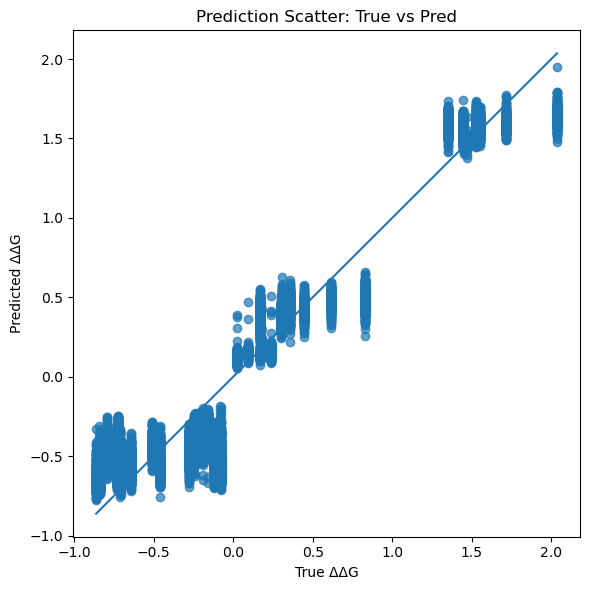

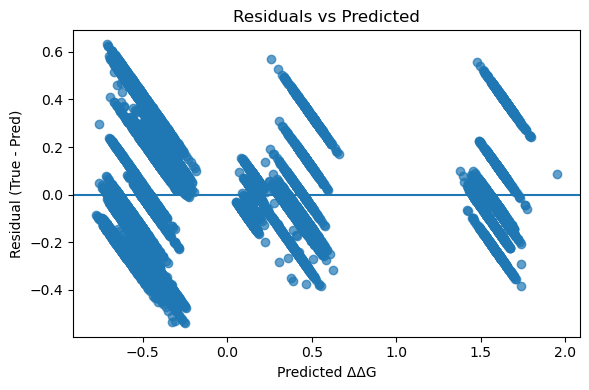

In [18]:

# 1) y_true vs y_pred
plt.figure(figsize=(6,6))
plt.scatter(pred_df['y_true'], pred_df['y_pred'], alpha=0.7)
minv, maxv = pred_df[['y_true','y_pred']].min().min(), pred_df[['y_true','y_pred']].max().max()
plt.plot([minv, maxv], [minv, maxv])
plt.xlabel("True ΔΔG")
plt.ylabel("Predicted ΔΔG")
plt.title("Prediction Scatter: True vs Pred")
plt.tight_layout()
plt.show()

# 2) Residuals
residuals = pred_df['y_true'] - pred_df['y_pred']
plt.figure(figsize=(6,4))
plt.scatter(pred_df['y_pred'], residuals, alpha=0.7)
plt.axhline(0)
plt.xlabel("Predicted ΔΔG")
plt.ylabel("Residual (True - Pred)")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.show()



## 10. Feature Importance (Impurity-based)

Bar chart of the **top 20** features by Gini (impurity) importance from the trained RF.


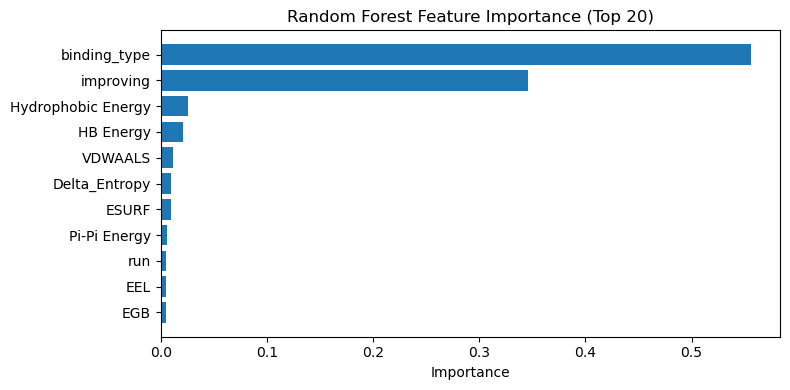

Saved feature importances -> /Users/nakku/Desktop/ML-Protein-DNA-Binding-Affinity/ML-Protein-DNA-Binding-Affinity/tutorial notebooks/ML_RF_CV_02/rf_feature_importance.csv


In [19]:

importances = rf.feature_importances_
imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances}).sort_values('importance', ascending=False)

topk = 20 if len(imp_df) > 20 else len(imp_df)
top_imp = imp_df.head(topk)

plt.figure(figsize=(8, max(4, topk*0.3)))
plt.barh(top_imp['feature'][::-1], top_imp['importance'][::-1])
plt.xlabel("Importance")
plt.title("Random Forest Feature Importance (Top 20)")
plt.tight_layout()
plt.show()

# Save full importance table
imp_path = OUTPUT_DIR / 'rf_feature_importance.csv'
imp_df.to_csv(imp_path, index=False)
print("Saved feature importances ->", imp_path)



## 11. Permutation Importance (on Test Set)

Model-agnostic importances based on **performance drop** when permuting each feature.


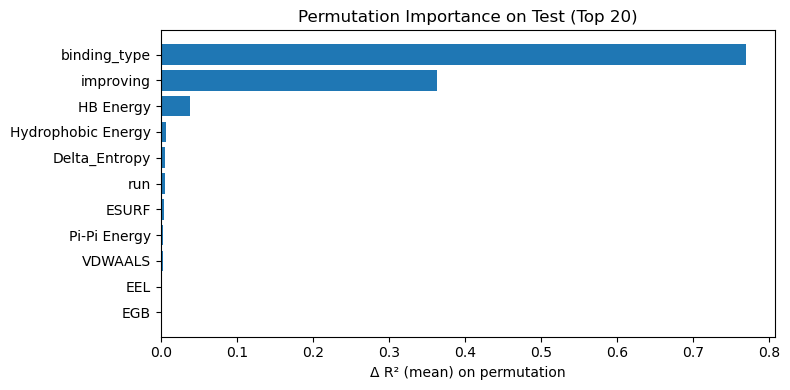

Saved permutation importances -> /Users/nakku/Desktop/ML-Protein-DNA-Binding-Affinity/ML-Protein-DNA-Binding-Affinity/tutorial notebooks/ML_RF_CV_02/rf_permutation_importance.csv


/opt/anaconda3/envs/mmgbsa_ml/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:

perm = permutation_importance(rf, X_test, y_test, scoring='r2', n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)
perm_imp = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': perm.importances_mean,
    'importance_std': perm.importances_std
}).sort_values('importance_mean', ascending=False)

topk = 20 if len(perm_imp) > 20 else len(perm_imp)
top_perm = perm_imp.head(topk)

plt.figure(figsize=(8, max(4, topk*0.3)))
plt.barh(top_perm['feature'][::-1], top_perm['importance_mean'][::-1])
plt.xlabel("Δ R² (mean) on permutation")
plt.title("Permutation Importance on Test (Top 20)")
plt.tight_layout()
plt.show()

perm_path = OUTPUT_DIR / 'rf_permutation_importance.csv'
perm_imp.to_csv(perm_path, index=False)
print("Saved permutation importances ->", perm_path)



## 12. Partial Dependence (PDP)

For the **top 3** important features (by impurity importance), show PDP to visualize the marginal effect on predictions.


Top 3 features for PDP: ['binding_type', 'improving', 'Hydrophobic Energy']


<Figure size 600x400 with 0 Axes>

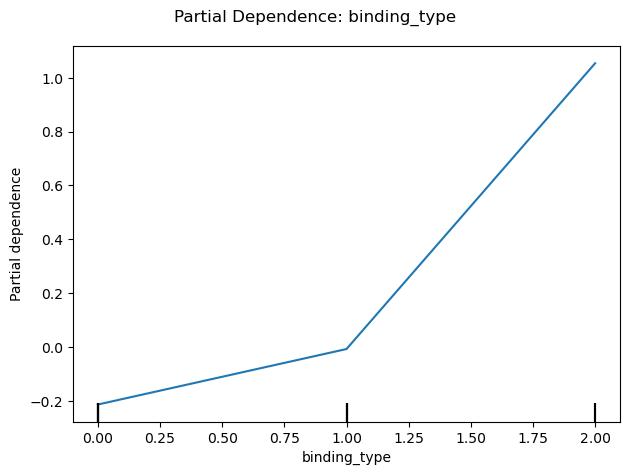

<Figure size 600x400 with 0 Axes>

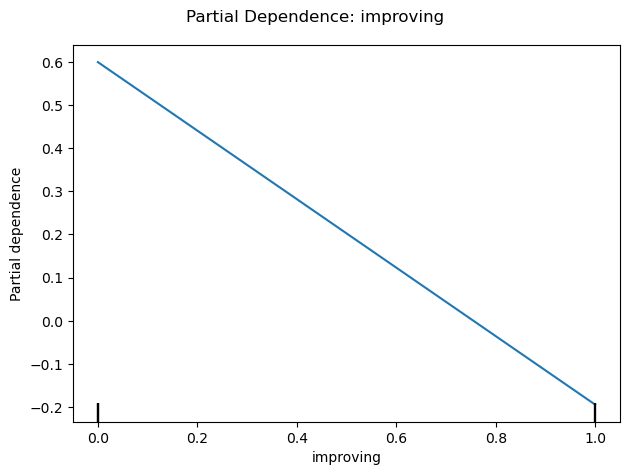

<Figure size 600x400 with 0 Axes>

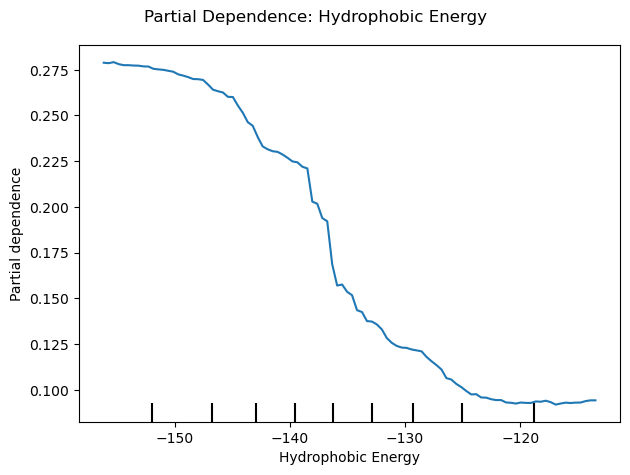

In [21]:

top3_feats = imp_df['feature'].head(3).tolist()
print("Top 3 features for PDP:", top3_feats)

for feat in top3_feats:
    plt.figure(figsize=(6,4))
    try:
        PartialDependenceDisplay.from_estimator(rf, X_train, [feat])
        plt.suptitle(f"Partial Dependence: {feat}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Skipping PDP for {feat}: {e}")



## 13. Learning Curve

Does adding more training data help? Use **learning_curve** to visualize training vs validation scores.


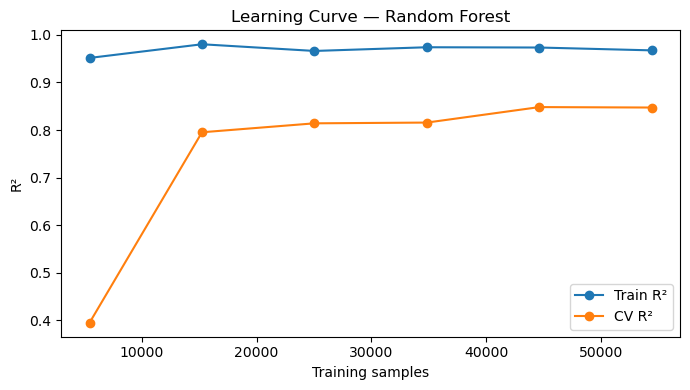

In [22]:

train_sizes, train_scores, val_scores = learning_curve(
    rf, X, y, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 6), random_state=RANDOM_STATE
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

plt.figure(figsize=(7,4))
plt.plot(train_sizes, train_mean, marker='o', label='Train R²')
plt.plot(train_sizes, val_mean, marker='o', label='CV R²')
plt.xlabel("Training samples")
plt.ylabel("R²")
plt.title("Learning Curve — Random Forest")
plt.legend()
plt.tight_layout()
plt.show()



## 14. Cross-validated Predictions (CV = 5)

Use `cross_val_predict` to get out-of-fold predictions for each sample and visualize **True vs Pred**.


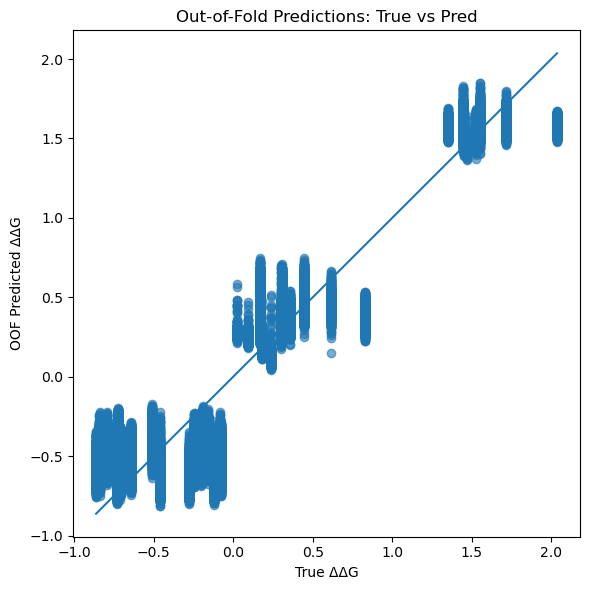

OOF — R²: 0.9044 | RMSE: 0.2581 | MAE: 0.2110


In [23]:

oof_pred = cross_val_predict(rf, X, y, cv=5, n_jobs=-1)

plt.figure(figsize=(6,6))
plt.scatter(y, oof_pred, alpha=0.6)
minv, maxv = min(y.min(), oof_pred.min()), max(y.max(), oof_pred.max())
plt.plot([minv, maxv], [minv, maxv])
plt.xlabel("True ΔΔG")
plt.ylabel("OOF Predicted ΔΔG")
plt.title("Out-of-Fold Predictions: True vs Pred")
plt.tight_layout()
plt.show()

oof_r2 = r2_score(y, oof_pred)
oof_rmse = math.sqrt(mean_squared_error(y, oof_pred))
oof_mae = mean_absolute_error(y, oof_pred)
print(f"OOF — R²: {oof_r2:.4f} | RMSE: {oof_rmse:.4f} | MAE: {oof_mae:.4f}")



## 15. Randomized Hyperparameter Search

Try a quick **RandomizedSearchCV** to explore better RF settings. Adjust `n_iter` for thoroughness (trade-off with runtime).


In [24]:

param_distributions = {
    'n_estimators': np.arange(200, 1001, 100),
    'max_depth': [None] + list(range(8, 33, 4)),
    'min_samples_split': [2, 3, 4, 5, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

rf_base = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)

search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=40,                # increase for more thorough search
    scoring='r2',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)
print("Best params:", search.best_params_)
print("Best CV R²:", search.best_score_)

# Evaluate best model on the holdout test set
best_rf = search.best_estimator_
y_pred_best = best_rf.predict(X_test)
print("Best RF — Test R²:", r2_score(y_test, y_pred_best))
print("Best RF — Test RMSE:", math.sqrt(mean_squared_error(y_test, y_pred_best)))
print("Best RF — Test MAE:", mean_absolute_error(y_test, y_pred_best))

# Save best model
best_model_path = OUTPUT_DIR / 'rf_model_best.pkl'
joblib.dump(best_rf, best_model_path)
print("Saved best model ->", best_model_path)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


KeyboardInterrupt: 


## 16. Save Final Artifacts & Metrics

Persist model, metrics, and configuration for reproducibility.


In [ ]:

# Save baseline (non-tuned) model too
base_model_path = OUTPUT_DIR / 'rf_model_baseline.pkl'
joblib.dump(rf, base_model_path)

metrics = {
    'baseline_cv': {
        'r2_mean': float(np.mean(cv_r2)),
        'rmse_mean': float(np.mean(np.sqrt(-cv_mse))),
        'mae_mean': float(np.mean(-cv_mae))
    },
    'holdout_baseline': {
        'r2': float(test_r2),
        'rmse': float(test_rmse),
        'mae': float(test_mae)
    },
    'oof': {
        'r2': float(oof_r2),
        'rmse': float(oof_rmse),
        'mae': float(oof_mae)
    }
}

metrics_path = OUTPUT_DIR / 'metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)

config = {
    'SEQUENCE_ID': SEQUENCE_ID,
    'LABEL_COL': LABEL_COL,
    'feature_cols': feature_cols,
    'RANDOM_STATE': RANDOM_STATE
}
config_path = OUTPUT_DIR / 'config.json'
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)

print("Saved:")
print(" - Baseline model ->", base_model_path)
print(" - Metrics ->", metrics_path)
print(" - Config ->", config_path)



## 17. Next Steps / Ideas

- Try **GroupKFold** if you have grouping structure (e.g., protein family) to prevent leakage.
- Compare models: Gradient Boosting, XGBoost/LightGBM, ExtraTrees.
- Calibrate uncertainty: Quantile RF or conformal prediction for ΔΔG intervals.
- Feature engineering: domain-inspired aggregates, interaction terms.
- Model interpretation: ALE plots (Accumulated Local Effects), SHAP (if available).
